In [11]:
import numpy as np
# from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

import src.tera_project_preprocess as preprocess

# Importação e tratamento dos dados

A partir da EDA, chegamos a conclusão de que devemos trabalhar com os dados com uma transformação diferencial.

In [2]:
# Importa e transforma o date em tipo datetime e define como index
data_path = 'C:\\Tera\\Projeto\\data\\milho-cepea.csv'
date_column = 'date'
series = preprocess.load_timeseries_csv(data_path,date_column)
series.head()

,RS,US
date,,
2004-01-05,20.83,7.30
2004-01-12,19.66,7.05
2004-07-30,18.14,5.97
2004-08-02,18.24,5.98
2004-08-03,18.04,5.91


In [3]:
data = series['RS']
data_diff = np.diff(data)

In [4]:
data_diff_df = data.diff(periods=1)

# Determinando os dados de treinamento e de teste

Vamos utilizar 90% dos dados para treino e 10% para teste

In [5]:
train = data_diff[:int(0.9*len(data_diff))]
test = data_diff[int(0.9*len(data_diff)):]

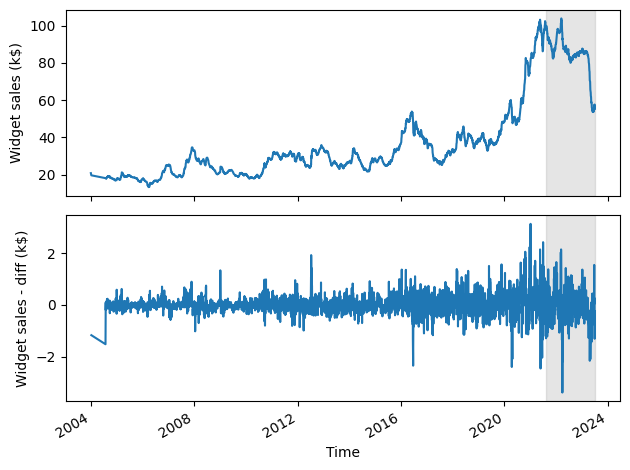

In [6]:
import matplotlib.pyplot as plt

interval = len(data_diff_df) - len(test)

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True)

ax1.plot(data)
ax1.set_xlabel('Time')
ax1.set_ylabel('Widget sales (k$)')
ax1.axvspan(data_diff_df.index[interval], data_diff_df.index[-1], color='#808080', alpha=0.2)

ax2.plot(data_diff_df)
ax2.set_xlabel('Time')
ax2.set_ylabel('Widget sales - diff (k$)')
ax2.axvspan(data_diff_df.index[interval], data_diff_df.index[-1], color='#808080', alpha=0.2)


fig.autofmt_xdate()
plt.tight_layout()

# Autocorrelação

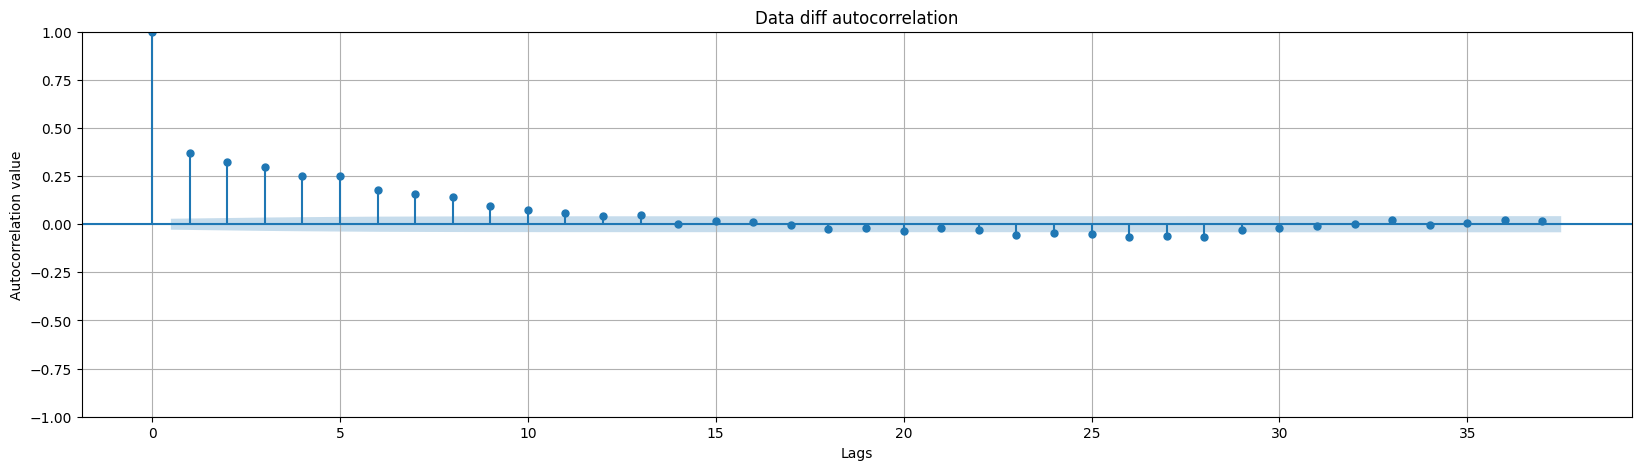

[[0, 1.0],
 [1, 0.36784823250501597],
 [2, 0.32358561846524725],
 [3, 0.2956532833596805],
 [4, 0.25252649795225524],
 [5, 0.2505035847933827],
 [6, 0.17586200739859112],
 [7, 0.15494777559845038],
 [8, 0.1439776015637434],
 [9, 0.09532584765957951],
 [10, 0.07239573192944904],
 [11, 0.055807574592055424],
 [23, -0.05616019249260079],
 [25, -0.052089262083841806],
 [26, -0.06794015384138888],
 [27, -0.061300518342501886],
 [28, -0.06736770422928863]]

In [7]:
alpha = 0.05
acf = preprocess.acf_info(data_diff, alpha=alpha, title_value='Data diff autocorrelation')
relevant_acf = []
for i in range(len(acf)):
    if abs(acf[i]) >= alpha:
        relevant_acf.append([i, acf[i]])

relevant_acf

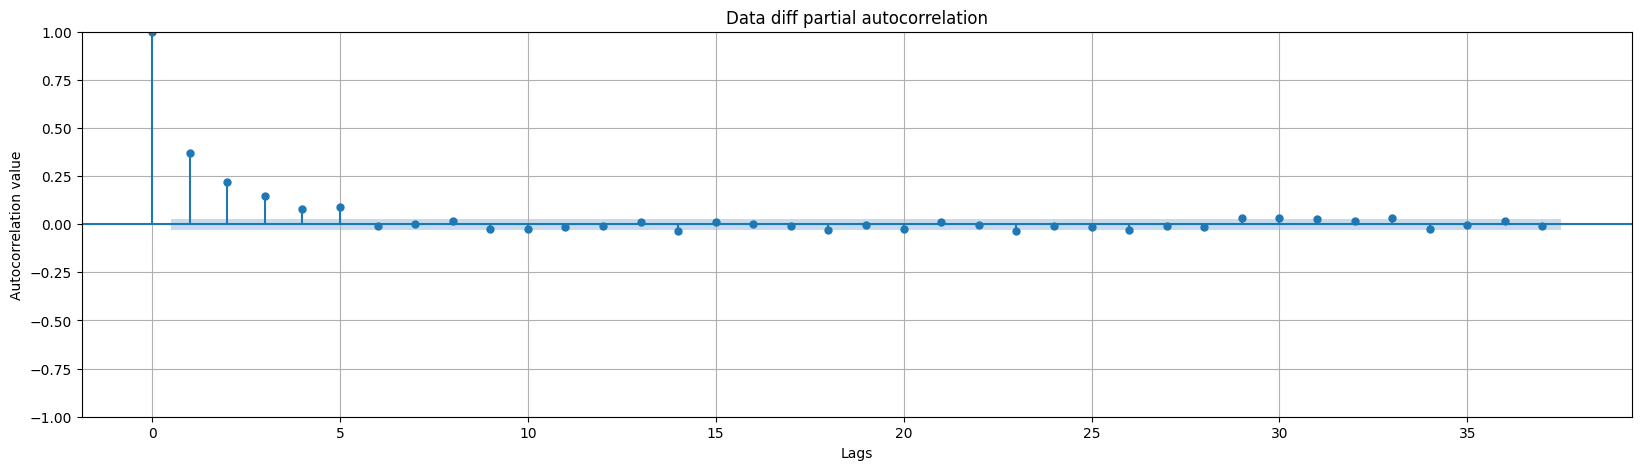

[[0, 1.0],
 [1, 0.36792633191743734],
 [2, 0.217842567232141],
 [3, 0.1487761101168591],
 [4, 0.08169382133534701],
 [5, 0.08785483025158582]]

In [8]:
pacf = preprocess.pacf_info(data_diff, alpha=alpha, title_value='Data diff partial autocorrelation')
relevant_pacf = []
for i in range(len(pacf)):
    if abs(pacf[i]) >= alpha:
        relevant_pacf.append([i, pacf[i]])

relevant_pacf

# Forecast

p = representa a ordem de autoregressão

d = grau de diferenciação

q = ordem de média móvel (combinação linear dos erros de valores passados)

Interpretação dos gráficos de ACF e PACF:

ACF com Decaimento Gradual e PACF com Corte Brusco:

Se o gráfico de ACF mostra uma decaída gradual, enquanto o gráfico de PACF tem cortes bruscos, um modelo AR(p) pode ser adequado, onde "p" é o número de lags significativos antes do declínio no gráfico de ACF.
ACF e PACF com Decaimento Gradual:

Se ambos os gráficos de ACF e PACF mostram uma decaída gradual, pode ser indicativo de um modelo ARMA(p, q), onde "p" é o número de lags significativos no gráfico de ACF e "q" é o número de lags significativos no gráfico de PACF.
ACF e PACF sem Lags Significativos:

Se ambos os gráficos de ACF e PACF não têm lags significativos, um modelo ARIMA(p, d, q) pode ser apropriado, onde "p" é 0 e "q" é 0.
___
Interpretação:

Se o gráfico de ACF decai rapidamente para zero, isso sugere que a série temporal é estacionária, e você pode considerar um modelo de média móvel (MA) com um valor "q" baseado no último lag significativo antes do decaimento.

Se o gráfico de ACF decai lentamente e permanece significativo por muitos lags, isso sugere uma tendência autorregressiva (AR), e você pode considerar um modelo autorregressivo (AR) com um valor "p" baseado no último lag significativo antes do decaimento.

## Modelo MA

Modelo MA: (0,q,0)

Para determinar se o modelo MA é o correto para os dados em questão, devemos observar o gráfico ACF da série estacionária. Caso existam coeficientes significativos e abruptamente após um lag q, os próximos lags não sejam mais significativos, a série é "moving avarage process" e a ordem q é o último lag significativo.

Esse comportamento não é visto nos nossos dados, porém, vamos desenvolver o modelo MA(q) e ver seus resultados como forma de estudo.

In [13]:
q = 11
model_ma = SARIMAX(test, order=(0,0,q))
res = model_ma.fit(disp=False)
print(res.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  472
Model:              SARIMAX(0, 0, 11)   Log Likelihood                -363.721
Date:                Sat, 05 Aug 2023   AIC                            751.442
Time:                        19:30:12   BIC                            801.325
Sample:                             0   HQIC                           771.064
                                - 472                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.2356      0.044      5.329      0.000       0.149       0.322
ma.L2          0.1862      0.043      4.294      0.000       0.101       0.271
ma.L3          0.2600      0.046      5.686      0.0

In [18]:
prevision_ma = res.predict(start=0, end=20)

In [19]:
prevision_ma

array([ 0.        , -0.43294421, -0.22743329, -0.06857147,  0.33064811,
        0.09126489,  0.14466487, -0.0973667 , -0.06083598, -0.11435377,
       -0.13402816, -0.29431431, -0.2662457 , -0.29474598, -0.4148316 ,
       -0.31590849, -0.46416923, -0.42440729, -0.60721822, -0.32966699,
       -0.32176709])